In [69]:
import torch
from torch import nn

from sklearn import preprocessing

import pandas as pd
import numpy as np

from tqdm.auto import tqdm

In [70]:
data_path = "C:/Users/kamal/Downloads/climate_change_data.csv"
df = pd.read_csv(data_path)

df.head()

,Date,Location,Country,Temperature,CO2_concentration,Sea_level_rise,Precipitation,Humidity,Wind_speed
0,01/01/2000,New Williamtown,Latvia,10.688986,403.118902,0.717506,13.835237,23.631256,18.492026
1,01/01/2000,North Rachel,South Africa,13.814430,396.663499,1.205715,40.974084,43.982946,34.249300
2,02/01/2000,West Williamland,French Guiana,27.323718,451.553155,-0.160783,42.697931,96.652600,34.124261
3,03/01/2000,South David,Vietnam,12.309581,422.404984,-0.475931,5.193341,47.467938,8.554563
4,04/01/2000,New Scottburgh,Moldova,13.210885,410.472999,1.135757,78.695280,61.789672,8.001164


## HELPER FUNCTIONS

In [71]:
def handle_non_num_data(df):
    columns = df.columns.values
    for col in columns:
        text_digit_vals = {}

        def convert_to_int_val(val):
            return text_digit_vals[val]

        if df[col].dtype != np.int64 and df[col].dtype != np.float64:
            column_contents = df[col].values.tolist()
            unique_el = set(column_contents)

            x = 0
            for unique in unique_el:
                if unique not in text_digit_vals:
                    text_digit_vals[unique] = x
                    x += 1
            df[col] = list(map(convert_to_int_val, df[col]))

    return df

def acc_fn(y_true , y_pred):
    correct = torch.eq(y_true , y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc 

## DATA PROCESSING

In [72]:
df = handle_non_num_data(df)
df.head()

,Date,Location,Country,Temperature,CO2_concentration,Sea_level_rise,Precipitation,Humidity,Wind_speed
0,71,5410,237,10.688986,403.118902,0.717506,13.835237,23.631256,18.492026
1,71,2866,151,13.814430,396.663499,1.205715,40.974084,43.982946,34.249300
2,8246,2084,173,27.323718,451.553155,-0.160783,42.697931,96.652600,34.124261
3,1986,5854,13,12.309581,422.404984,-0.475931,5.193341,47.467938,8.554563
4,5184,4119,204,13.210885,410.472999,1.135757,78.695280,61.789672,8.001164


In [73]:
X = np.array(df.drop(["Date" , "Location" , "Country" , "Sea_level_rise"]  , axis = 1)).astype(float)
X = preprocessing.scale(X)
y = np.array(df["Sea_level_rise"])

In [74]:
X[:5] , y[:5]

(array([[-0.84428235,  0.0583251 , -1.24895198, -0.90362832, -0.45555605],
        [-0.22296665, -0.0715768 , -0.30862173, -0.20009616,  0.63371229],
        [ 2.46258188,  1.03296623, -0.24889237,  1.62062717,  0.62506861],
        [-0.52211988,  0.44641837, -1.54838386, -0.07962437, -1.14251267],
        [-0.34294707,  0.20631137,  0.9983749 ,  0.41545984, -1.18076806]]),
 array([ 0.71750603,  1.20571458, -0.16078297, -0.47593147,  1.13575663]))

In [75]:
split = len(X) - int(len(X) * 0.2)

X, y= torch.tensor(X, dtype = torch.float) , torch.tensor(y , dtype = torch.float)

X = nn.functional.normalize(X)

X_train = X[:split]
X_test = X[split:]
y_train = y[:split]
y_test = y[split:]

In [76]:
device = "cuda" if torch.cuda.is_available() else "cpu"

X_train , X_test = X_train.to(device) , X_test.to(device)
y_train , y_test =  y_train.to(device) , y_test.to(device)

## BUILDING A MODEL

In [77]:
class ClusterNN(nn.Module):
    def __init__(self , input_shape , hidden_units , output_shape):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(in_features = input_shape , out_features = hidden_units),
            nn.ReLU(),

            nn.Linear(in_features=hidden_units , out_features = hidden_units),
            nn.ReLU(),

            nn.Linear(in_features=hidden_units , out_features= output_shape)
        )

    def forward(self , X):
        X = self.layer1(X)
        return X
    
model = ClusterNN(X_train.shape[1] , 64 , 1).to(device)

loss_fn = nn.MSELoss()

optimizer = torch.optim.SGD(params = model.parameters() , lr = 0.001)

## TRAINING LOOP

In [78]:
EPOCHS = 500
y_pred = []

for epoch in tqdm(range(EPOCHS)):
    model.train()
    # Forward pass
    y_logits = model(X_train).squeeze()

    # y_pred = torch.round(torch.sigmoid(y_logits))

    # Calculate Loss , Accuracy
    loss = loss_fn(y_logits , y_train)

    acc = acc_fn(y_train , y_logits)
    y_pred = y_logits
    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    # TESTING LOOP
    model.eval()

    with torch.inference_mode():
        test_logits = model(X_test).squeeze()

        # test_pred = torch.round(torch.sigmoid(test_logits))

        # Calculate test loss and accuracy
        test_loss = loss_fn(test_logits , y_test)

        test_acc = acc_fn(y_test , test_logits)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.3f} | Test Loss: {test_loss:.3f}")

  2%|▏         | 12/500 [00:00<00:08, 58.32it/s]

Epoch: 0 | Loss: 0.972 , Acc:0.00% | Test Loss: 1.043 , Test Acc: 0.00%
Epoch: 10 | Loss: 0.971 , Acc:0.00% | Test Loss: 1.043 , Test Acc: 0.00%


 13%|█▎        | 66/500 [00:00<00:02, 202.89it/s]

Epoch: 20 | Loss: 0.971 , Acc:0.00% | Test Loss: 1.043 , Test Acc: 0.00%
Epoch: 30 | Loss: 0.971 , Acc:0.00% | Test Loss: 1.043 , Test Acc: 0.00%
Epoch: 40 | Loss: 0.970 , Acc:0.00% | Test Loss: 1.043 , Test Acc: 0.00%
Epoch: 50 | Loss: 0.970 , Acc:0.00% | Test Loss: 1.042 , Test Acc: 0.00%
Epoch: 60 | Loss: 0.970 , Acc:0.00% | Test Loss: 1.042 , Test Acc: 0.00%
Epoch: 70 | Loss: 0.970 , Acc:0.00% | Test Loss: 1.042 , Test Acc: 0.00%
Epoch: 80 | Loss: 0.970 , Acc:0.00% | Test Loss: 1.042 , Test Acc: 0.00%
Epoch: 90 | Loss: 0.970 , Acc:0.00% | Test Loss: 1.042 , Test Acc: 0.00%


 27%|██▋       | 136/500 [00:00<00:01, 279.54it/s]

Epoch: 100 | Loss: 0.969 , Acc:0.00% | Test Loss: 1.042 , Test Acc: 0.00%
Epoch: 110 | Loss: 0.969 , Acc:0.00% | Test Loss: 1.042 , Test Acc: 0.00%
Epoch: 120 | Loss: 0.969 , Acc:0.00% | Test Loss: 1.042 , Test Acc: 0.00%
Epoch: 130 | Loss: 0.969 , Acc:0.00% | Test Loss: 1.042 , Test Acc: 0.00%
Epoch: 140 | Loss: 0.969 , Acc:0.00% | Test Loss: 1.042 , Test Acc: 0.00%
Epoch: 150 | Loss: 0.969 , Acc:0.00% | Test Loss: 1.042 , Test Acc: 0.00%
Epoch: 160 | Loss: 0.969 , Acc:0.00% | Test Loss: 1.042 , Test Acc: 0.00%


 42%|████▏     | 210/500 [00:00<00:00, 326.22it/s]

Epoch: 170 | Loss: 0.969 , Acc:0.00% | Test Loss: 1.042 , Test Acc: 0.00%
Epoch: 180 | Loss: 0.969 , Acc:0.00% | Test Loss: 1.042 , Test Acc: 0.00%
Epoch: 190 | Loss: 0.969 , Acc:0.00% | Test Loss: 1.042 , Test Acc: 0.00%
Epoch: 200 | Loss: 0.969 , Acc:0.00% | Test Loss: 1.042 , Test Acc: 0.00%
Epoch: 210 | Loss: 0.969 , Acc:0.00% | Test Loss: 1.042 , Test Acc: 0.00%
Epoch: 220 | Loss: 0.968 , Acc:0.00% | Test Loss: 1.042 , Test Acc: 0.00%
Epoch: 230 | Loss: 0.968 , Acc:0.00% | Test Loss: 1.042 , Test Acc: 0.00%
Epoch: 240 | Loss: 0.968 , Acc:0.00% | Test Loss: 1.042 , Test Acc: 0.00%


 63%|██████▎   | 316/500 [00:01<00:00, 339.60it/s]

Epoch: 250 | Loss: 0.968 , Acc:0.00% | Test Loss: 1.042 , Test Acc: 0.00%
Epoch: 260 | Loss: 0.968 , Acc:0.00% | Test Loss: 1.042 , Test Acc: 0.00%
Epoch: 270 | Loss: 0.968 , Acc:0.00% | Test Loss: 1.042 , Test Acc: 0.00%
Epoch: 280 | Loss: 0.968 , Acc:0.00% | Test Loss: 1.042 , Test Acc: 0.00%
Epoch: 290 | Loss: 0.968 , Acc:0.00% | Test Loss: 1.042 , Test Acc: 0.00%
Epoch: 300 | Loss: 0.968 , Acc:0.00% | Test Loss: 1.042 , Test Acc: 0.00%
Epoch: 310 | Loss: 0.968 , Acc:0.00% | Test Loss: 1.042 , Test Acc: 0.00%


 71%|███████   | 354/500 [00:01<00:00, 349.80it/s]

Epoch: 320 | Loss: 0.968 , Acc:0.00% | Test Loss: 1.042 , Test Acc: 0.00%
Epoch: 330 | Loss: 0.968 , Acc:0.00% | Test Loss: 1.042 , Test Acc: 0.00%
Epoch: 340 | Loss: 0.968 , Acc:0.00% | Test Loss: 1.042 , Test Acc: 0.00%
Epoch: 350 | Loss: 0.968 , Acc:0.00% | Test Loss: 1.042 , Test Acc: 0.00%
Epoch: 360 | Loss: 0.968 , Acc:0.00% | Test Loss: 1.042 , Test Acc: 0.00%
Epoch: 370 | Loss: 0.968 , Acc:0.00% | Test Loss: 1.042 , Test Acc: 0.00%
Epoch: 380 | Loss: 0.968 , Acc:0.00% | Test Loss: 1.042 , Test Acc: 0.00%


 93%|█████████▎| 463/500 [00:01<00:00, 344.87it/s]

Epoch: 390 | Loss: 0.968 , Acc:0.00% | Test Loss: 1.042 , Test Acc: 0.00%
Epoch: 400 | Loss: 0.968 , Acc:0.00% | Test Loss: 1.042 , Test Acc: 0.00%
Epoch: 410 | Loss: 0.968 , Acc:0.00% | Test Loss: 1.042 , Test Acc: 0.00%
Epoch: 420 | Loss: 0.968 , Acc:0.00% | Test Loss: 1.042 , Test Acc: 0.00%
Epoch: 430 | Loss: 0.968 , Acc:0.00% | Test Loss: 1.042 , Test Acc: 0.00%
Epoch: 440 | Loss: 0.968 , Acc:0.00% | Test Loss: 1.042 , Test Acc: 0.00%
Epoch: 450 | Loss: 0.968 , Acc:0.00% | Test Loss: 1.042 , Test Acc: 0.00%
Epoch: 460 | Loss: 0.968 , Acc:0.00% | Test Loss: 1.042 , Test Acc: 0.00%


100%|██████████| 500/500 [00:01<00:00, 298.81it/s]

Epoch: 470 | Loss: 0.968 , Acc:0.00% | Test Loss: 1.042 , Test Acc: 0.00%
Epoch: 480 | Loss: 0.968 , Acc:0.00% | Test Loss: 1.042 , Test Acc: 0.00%
Epoch: 490 | Loss: 0.968 , Acc:0.00% | Test Loss: 1.042 , Test Acc: 0.00%


In [79]:
y_train = y_train.cpu().detach().numpy()

temp = X_train[: , 0].cpu().detach().numpy()
y_logits = y_logits.cpu().detach().numpy()


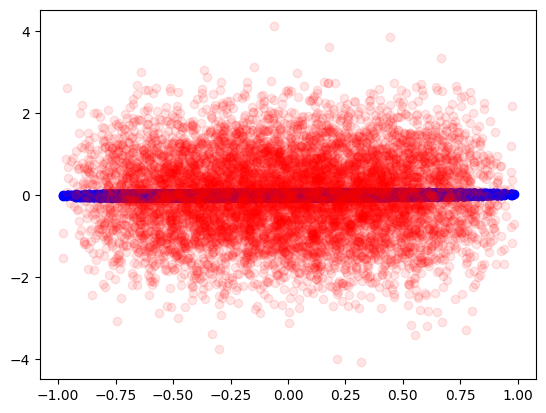

In [80]:
import matplotlib.pyplot as plt

plt.scatter(temp , y_logits , color = "blue")
plt.scatter(temp , y_train , color = "red" , alpha=0.1)